In [1]:
##Lib importing
##import torch
import numpy as np
import time
import random
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, models, datasets
from torchvision.utils import make_grid
from torch.optim import lr_scheduler
from PIL import Image, ImageOps
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix,f1_score, accuracy_score,precision_score, recall_score , multilabel_confusion_matrix,classification_report
import matplotlib.pyplot as plt
%matplotlib inline


import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
## using new data set
new_path_train='/content/drive/MyDrive/DataSets/Aug_Data/train'
new_path_test='/content/drive/MyDrive/DataSets/Aug_Data/test'

In [ ]:
## Data loader
transform=transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor()
    ])
df_X=datasets.ImageFolder(root=new_path_train, transform=transform)
validation_per=int(len(df_X) * 0.35)
train_per=len(df_X)-validation_per
train_data, val_data =random_split(df_X, [train_per, validation_per])
train_loader=DataLoader(train_data, batch_size=16, shuffle=True)
val_loader=DataLoader(val_data, batch_size=16, shuffle=False)
labels=df_X.classes
print(df_X.class_to_idx)

{'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2}


In [ ]:
from torchsummary import summary
torch.manual_seed(42)
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model= models.vgg16(pretrained=False)
##fixing output
model.classifier[6]=nn.Linear(in_features=4096, out_features=3)
model.to(device)
summary(model, input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [ ]:
#loss function
criterion=nn.CrossEntropyLoss()

In [ ]:
## lr
from torch.optim.lr_scheduler import StepLR
optimizer=torch.optim.Adam(model.parameters(), lr=0.001)
scheduler=torch.optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.5)

In [ ]:
##calculating f1,recall,..

def Show_Result_parameters(y_dataset, y_prediction):

    acc=accuracy_score(y_dataset,y_prediction)
    print(f'Accuracy Score:{acc:.4f}')
    f1=f1_score(y_dataset,y_prediction, average='macro', zero_division=0)
    print(f'F1 Score:{f1:.4f}')
    precision=precision_score(y_dataset, y_prediction, average='macro', zero_division=0)
    print(f'Precision Score:{precision:.4f}')
    recall=recall_score(y_dataset,y_prediction, average='macro', zero_division=0)
    print(f'Recall Score:{recall:.4f}')

In [ ]:
ENumbers=24
train_losses=[]
val_losses=[]
train_accuracies=[]
val_accuracies=[]

for epoch in range(ENumbers):
    start_time=time.time()
    model.train()
    running_train_loss=0.0
    trn_correct=0
    trn_total=0

    for tr_images, tclasss in train_loader:
        tr_images, tclasss = tr_images.to(device), tclasss.to(device)

        outputs=model(tr_images)
        loss=criterion(outputs, tclasss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_train_loss+=loss.item()

        # Accuracy: use argmax to get predicted class
        predicts=torch.argmax(outputs, dim=1)
        trn_correct+=(predicts == tclasss).sum().item()
        trn_total+=tclasss.size(0)

    avg_train_loss=running_train_loss/len(train_loader)
    train_accuracy=trn_correct/trn_total
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    #val data set
    model.eval()
    running_val_loss=0.0
    val_correct=0
    val_total=0
    y_predict=[]
    y_val=[]

    with torch.no_grad():
        for Val_images, classs in val_loader:
            Val_images, classs = Val_images.to(device), classs.to(device)
            outputs = model(Val_images)
            loss = criterion(outputs, classs)
            running_val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            val_correct+=(preds == classs).sum().item()
            val_total+=classs.size(0)

            y_predict.extend(preds.cpu().numpy())
            y_val.extend(classs.cpu().numpy())

    avg_val_loss = running_val_loss / len(val_loader)
    val_accuracy = val_correct / val_total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    scheduler.step()

    ##saving in case of internet dsconnecting :(((
    np.save("y_predict.npy", y_predict)
    np.save("y_val.npy", y_val)
    np.save('/content/drive/MyDrive/Hw2/vgg16/STEp_y_predict.npy', y_predict)
    np.save('/content/drive/MyDrive/Hw2/vgg16/STEp_y_val.npy', y_val)
    torch.save(model.state_dict(),'STEp_vgg16_Xray_CNN_HW2.pt')
    torch.save(model.state_dict(), "/content/drive/MyDrive/Hw2/vgg16/STEp_vgg16_Xray_CNN_HW2.pth")

    current_time=time.time()
    total_time=current_time-start_time
    print(f'Epoch =[{epoch+1} in {ENumbers}] Training takes {total_time/60} minutes')
    print(f'learning rate {scheduler.get_last_lr()[0]:.6f}')
    print(f'Training Loss: {avg_train_loss:.4f} & Training Acc: {train_accuracy:.4f} ** Validation Loss: {avg_val_loss:.4f} & Validation Acc: {val_accuracy:.4f}')
    print('parameters:')
    Show_Result_parameters(y_val,y_predict)
    print('------------------------------------------------------------')

Epoch =[1 in 24] Training takes 180.04825873772305 minutes
learning rate 0.001000
Training Loss: 1.3673 & Training Acc: 0.3285 ** Validation Loss: 1.0991 & Validation Acc: 0.3361
parameters:
Accuracy Score:0.3361
F1 Score:0.1677
Precision Score:0.1120
Recall Score:0.3333
------------------------------------------------------------
Epoch =[2 in 24] Training takes 155.15092374483746 minutes
learning rate 0.001000
Training Loss: 1.0996 & Training Acc: 0.3252 ** Validation Loss: 1.0988 & Validation Acc: 0.3257
parameters:
Accuracy Score:0.3257
F1 Score:0.1638
Precision Score:0.1086
Recall Score:0.3333
------------------------------------------------------------
Epoch =[3 in 24] Training takes 155.80624086062113 minutes
learning rate 0.001000
Training Loss: 1.0990 & Training Acc: 0.3344 ** Validation Loss: 1.0986 & Validation Acc: 0.3361
parameters:
Accuracy Score:0.3361
F1 Score:0.1677
Precision Score:0.1120
Recall Score:0.3333
------------------------------------------------------------
E

KeyboardInterrupt: 

In [ ]:
##saving the plotting variables
np.save("y_predict.npy", y_predict)
np.save("y_val.npy", y_val)
np.save('/content/drive/MyDrive/Hw2/vgg16/STEp_y_predict.npy', y_predict)
np.save('/content/drive/MyDrive/Hw2/vgg16/STEp_y_val.npy', y_val)
torch.save(model.state_dict(),'STEp_vgg16_Xray_CNN_HW2.pt')
torch.save(model.state_dict(), "/content/drive/MyDrive/Hw2/vgg16/STEp_vgg16_Xray_CNN_HW2.pth")

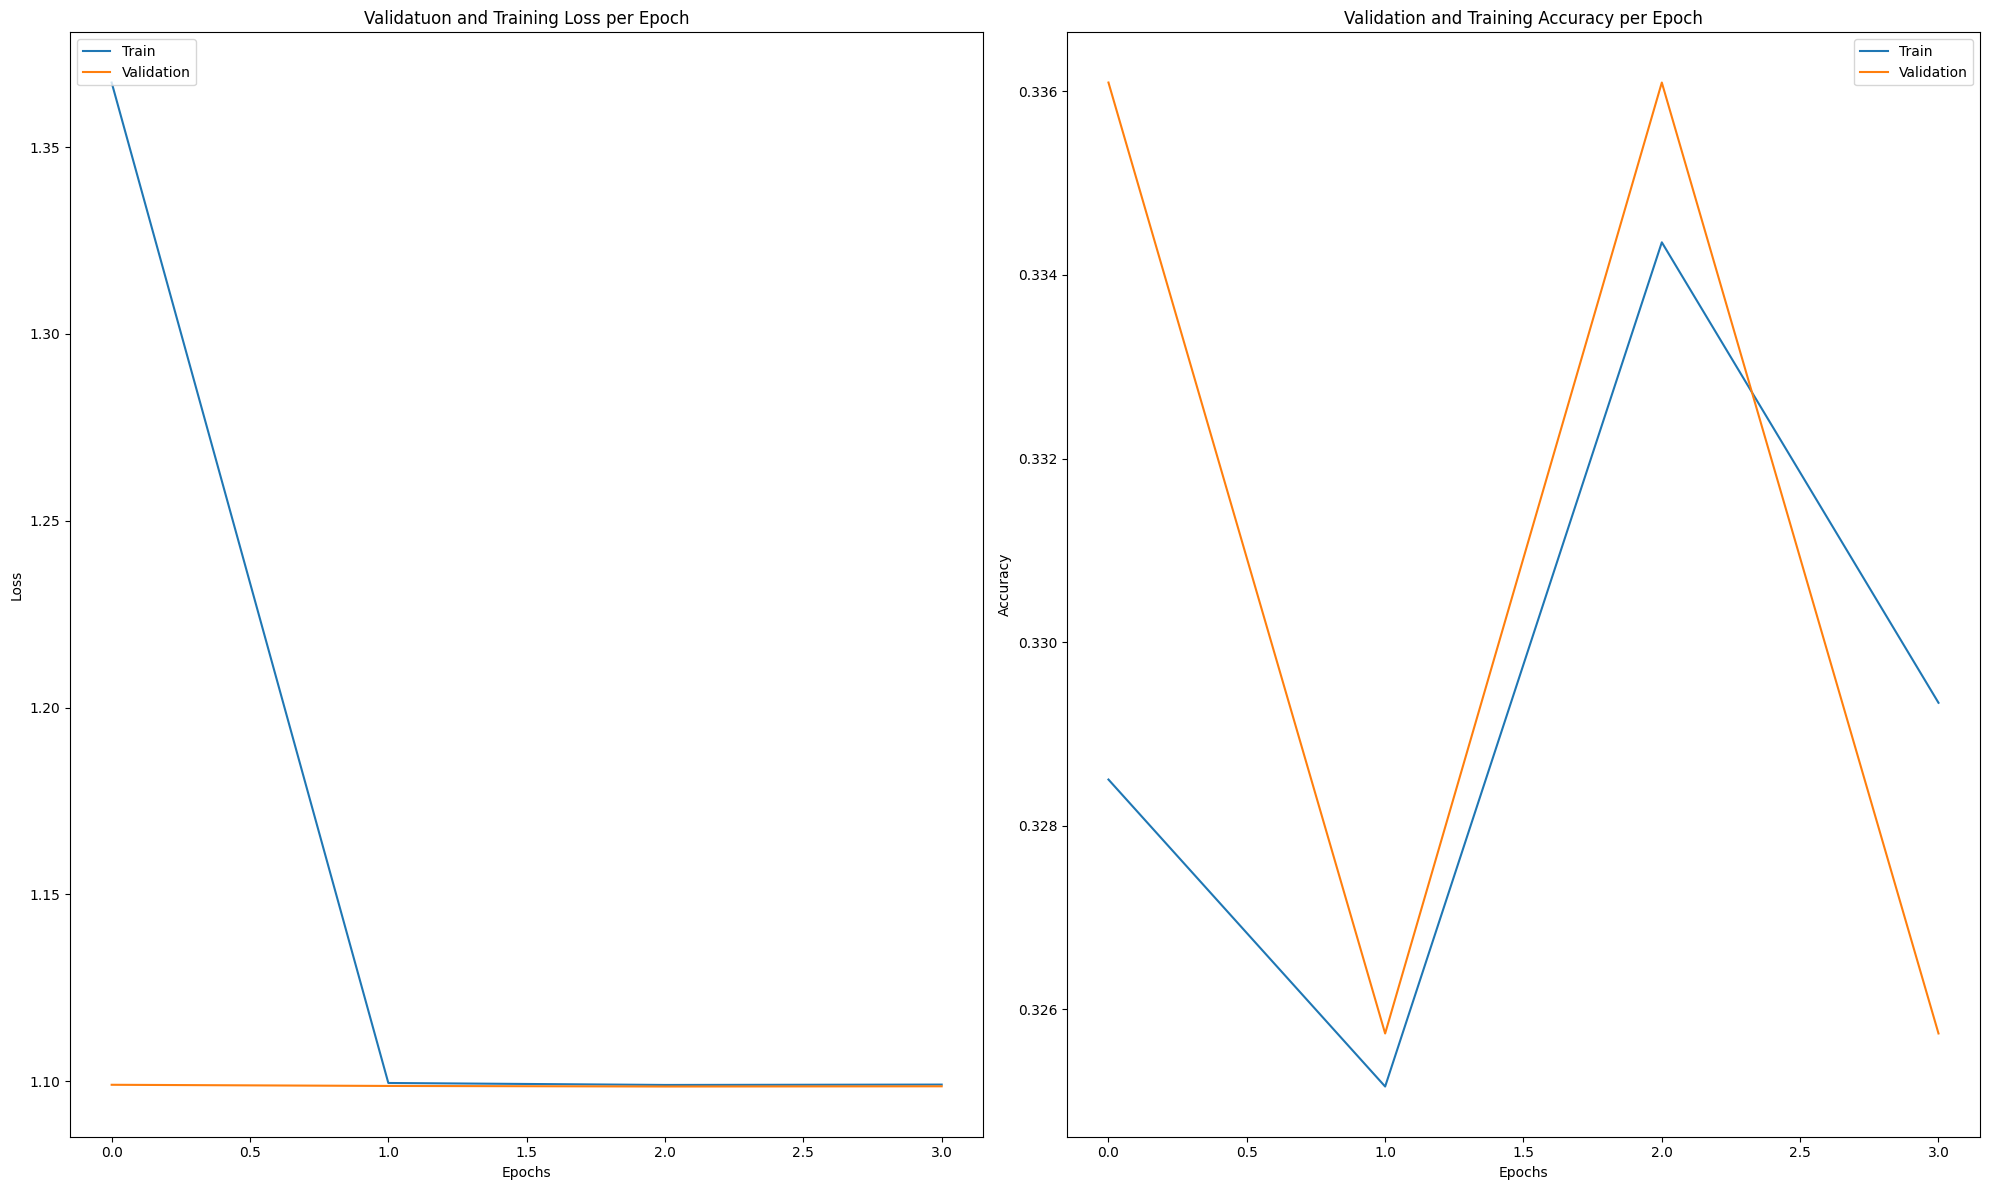

              precision    recall  f1-score   support

     COVID19       0.00      0.00      0.00       649
      NORMAL       0.33      1.00      0.49       629
   PNEUMONIA       0.00      0.00      0.00       653

    accuracy                           0.33      1931
   macro avg       0.11      0.33      0.16      1931
weighted avg       0.11      0.33      0.16      1931



In [ ]:
plt.figure(figsize=(20,12))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validatuon and Training Loss per Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation and Training Accuracy per Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

print((classification_report(y_val,y_predict, target_names=labels)))

{'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2}


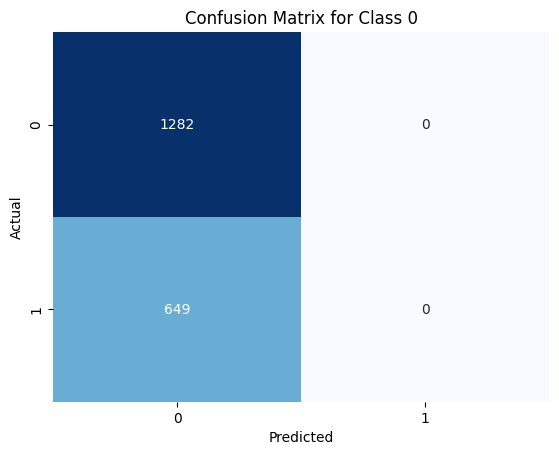

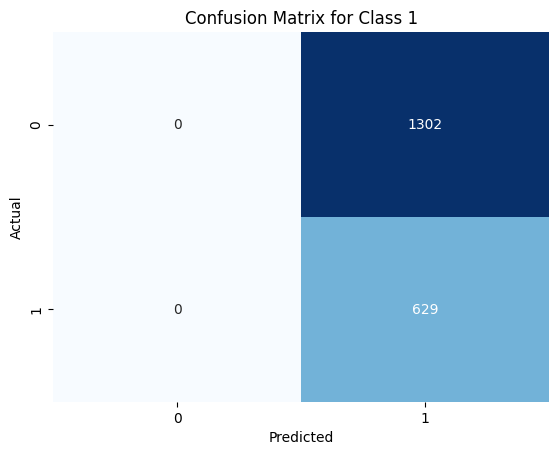

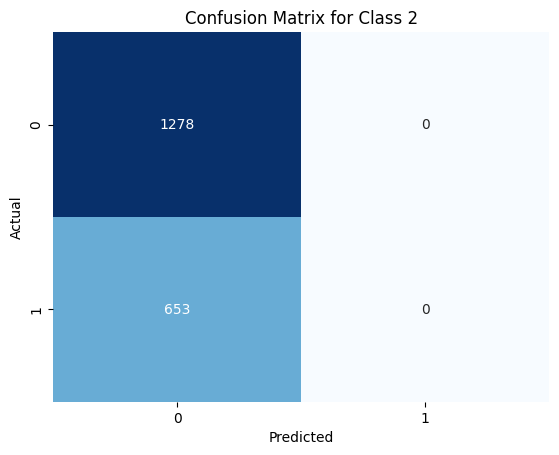

In [ ]:
ml_cm_1= multilabel_confusion_matrix(y_val,y_predict)
print(df_X.class_to_idx)
for i, cm in enumerate(ml_cm_1):
    plt.figure()
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix for Class {i}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [5]:
##testing
testing_model=models.vgg16(pretrained=False)
testing_model.classifier[6]=nn.Linear(in_features=4096, out_features=3)
testing_model.load_state_dict(torch.load('/content/drive/MyDrive/Hw2/vgg16/STEp_vgg16_Xray_CNN_HW2.pth'))
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
testing_model.to(device)
testing_model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [6]:
## Data loader
transform=transform=transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor()
    ])
dfT_X=datasets.ImageFolder(root=new_path_test, transform=transform)

test_loader=DataLoader(dfT_X, batch_size=16, shuffle=False)
Test_labelclass=dfT_X.classes

In [7]:
#using model
test_predict=[]
test_y=[]

with torch.no_grad():
    for test_X, test_class in test_loader:
        test_X=test_X.to(device)
        test_class = test_class.to(device)

        outputs=testing_model(test_X)
        preds=torch.argmax(outputs, dim=1)

        test_predict.extend(preds.cpu().numpy())
        test_y.extend(test_class.cpu().numpy())



In [8]:
np.save('/content/drive/MyDrive/Hw2/vgg16/STEp_y_test.npy', np.array(test_y))
np.save('/content/drive/MyDrive/Hw2/vgg16/STEp_y_test_preds.npy', np.array(test_predict))

In [9]:
print(classification_report(test_y, test_predict, target_names=Test_labelclass))


              precision    recall  f1-score   support

     COVID19       0.33      1.00      0.50       464
      NORMAL       0.00      0.00      0.00       464
   PNEUMONIA       0.00      0.00      0.00       464

    accuracy                           0.33      1392
   macro avg       0.11      0.33      0.17      1392
weighted avg       0.11      0.33      0.17      1392



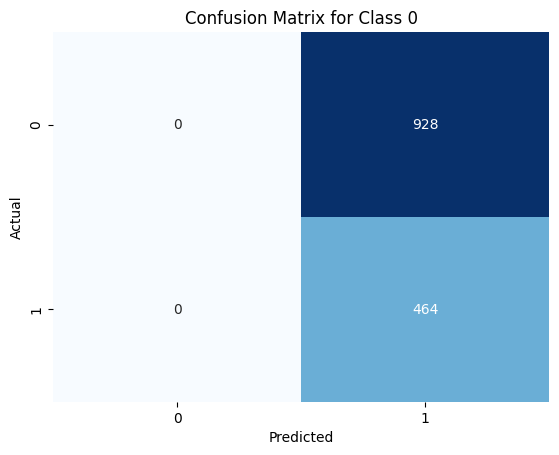

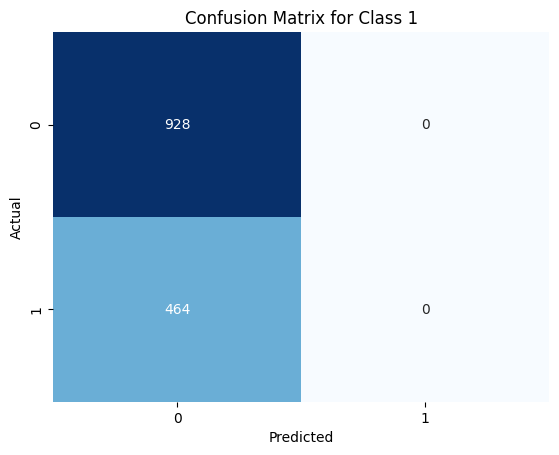

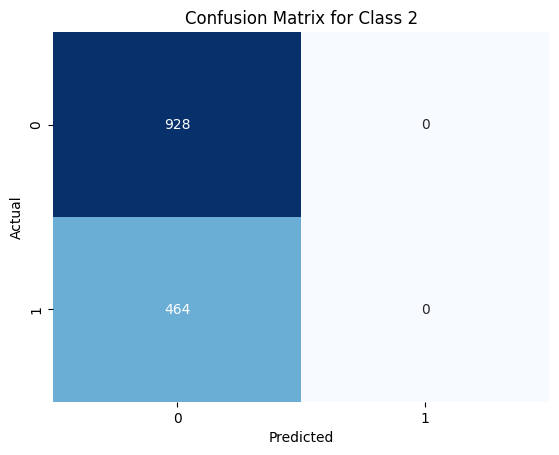

In [11]:
ml_cm_2= multilabel_confusion_matrix(test_y,test_predict)

for i, cm in enumerate(ml_cm_2):
    plt.figure()
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix for Class {i}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()